# Seleção de atributos

- Análise dos atributos escolhidos utilizando Random Forests.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from regression_utils import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFECV

In [2]:
NORMALIZE = False
ESTIMATORS = 100

# Análise de correlação

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,10))

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [4]:
train_df, test_df = get_train_test(1, normalize=False)
data_df = train_df.append(test_df, ignore_index=True)

In [5]:
data_df.columns.to_list()

['paredao',
 'nome',
 'positivos',
 'neutros',
 'negativos',
 'positivos_individual_pct',
 'neutros_individual_pct',
 'negativos_individual_pct',
 'positivos_global_pct',
 'neutros_global_pct',
 'negativos_global_pct',
 'day1',
 'day2',
 'day3',
 'likes',
 'retweets',
 'seguidores',
 'fica',
 'fora',
 'rejeicao']

In [6]:
translation = {
 'paredao': "elimination",
 'nome': "name",
 'positivos': "positive",
 'neutros': "neutral",
 'negativos': "negative",
 'positivos_individual_pct': "positive_individual_pct",
 'neutros_individual_pct': "neutral_individual_pct",
 'negativos_individual_pct': "negative_individual_pct",
 'positivos_global_pct': "positive_global_pct",
 'neutros_global_pct': "neutral_global_pct",
 'negativos_global_pct': "negative_global_pct",
 'seguidores': "followers",
 'rejeicao': "rejection"
}

In [7]:
translated_df = data_df.rename(columns=translation)

In [8]:
cor = translated_df.corr()

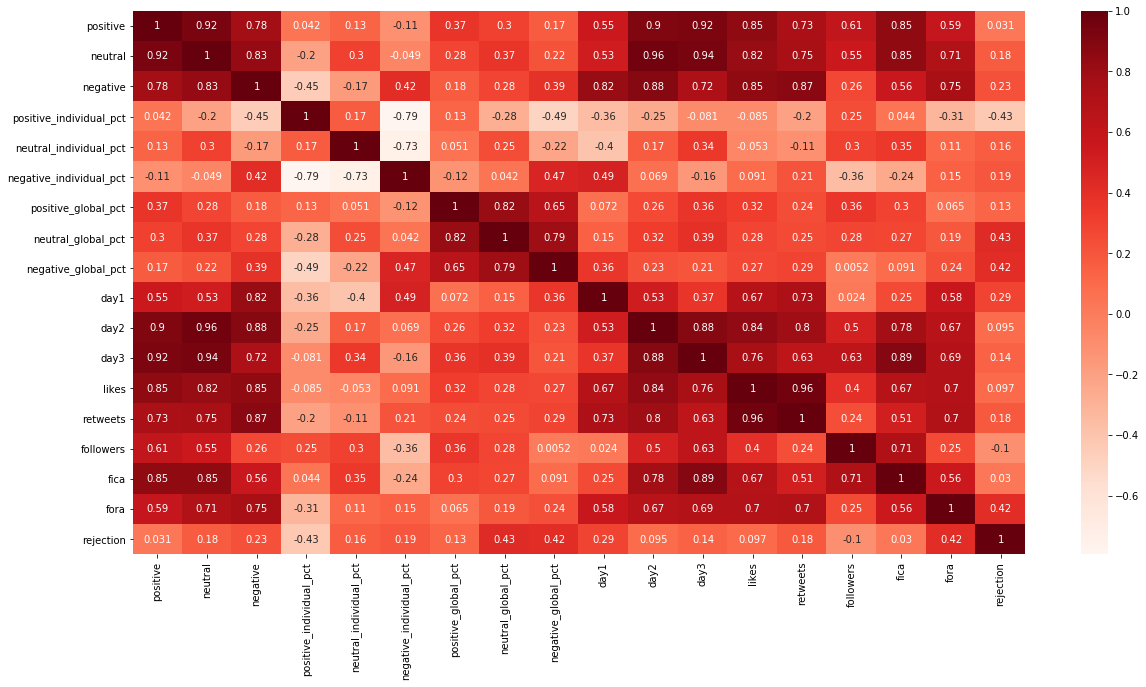

In [9]:
plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

- Ordenando por correlação

In [10]:
cor_target = abs(cor["rejection"])
cor_target.sort_values(ascending=False)

rejection                  1.000000
neutral_global_pct         0.431215
positive_individual_pct    0.428733
negative_global_pct        0.417141
fora                       0.417003
day1                       0.289279
negative                   0.227234
negative_individual_pct    0.194812
retweets                   0.182523
neutral                    0.176117
neutral_individual_pct     0.162825
day3                       0.139718
positive_global_pct        0.126399
followers                  0.104207
likes                      0.096679
day2                       0.094896
positive                   0.031029
fica                       0.030074
Name: rejection, dtype: float64

- Filtrando por correlação superior a 0.5

In [11]:
relevant_features = cor_target[cor_target > 0.5]

In [12]:
relevant_features

rejection    1.0
Name: rejection, dtype: float64

- Correlação ao atributo alvo (rejeicao) de todos os atributos

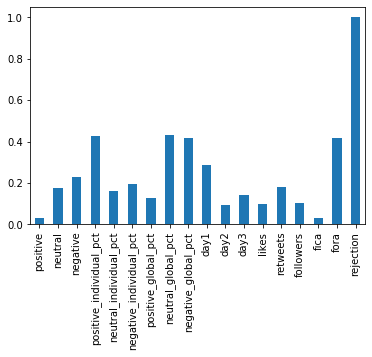

In [13]:
cor_target.plot.bar()

# Eliminando atributos correlacionados

In [14]:
correlated_features = set()
correlation_matrix = data_df.drop("rejeicao", axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [15]:
len(correlated_features)

9

In [16]:
correlated_features

{'day1',
 'day2',
 'day3',
 'fica',
 'likes',
 'negativos',
 'neutros',
 'neutros_global_pct',
 'retweets'}

# Análise de importancia de atributos

In [17]:
cols = data_df.drop(correlated_features, axis=1).columns

In [18]:
cols

Index(['paredao', 'nome', 'positivos', 'positivos_individual_pct',
       'neutros_individual_pct', 'negativos_individual_pct',
       'positivos_global_pct', 'negativos_global_pct', 'seguidores', 'fora',
       'rejeicao'],
      dtype='object')

In [19]:
summary_df = pd.DataFrame({"paredoes_decisivos": [0]*len(cols), "importancia_acumulada": [0]*len(cols)}, index=cols, columns=["paredoes_decisivos", "importancia_acumulada"])
summary_df.drop(index=["paredao", "nome", "rejeicao"], inplace=True)

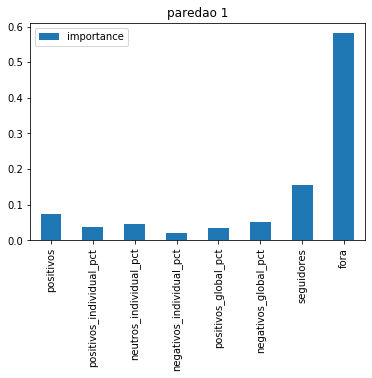

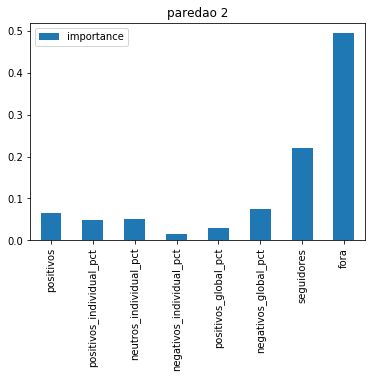

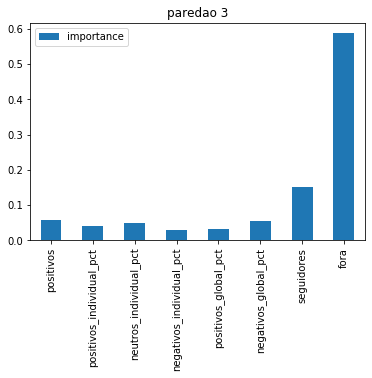

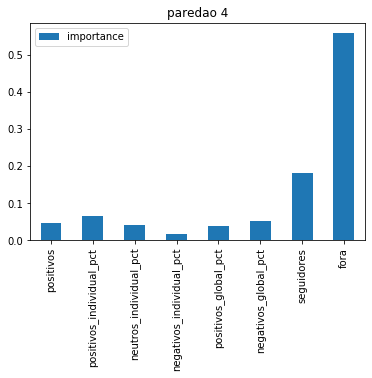

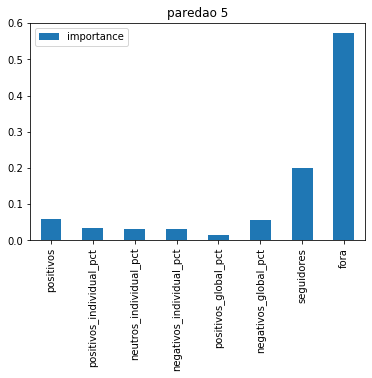

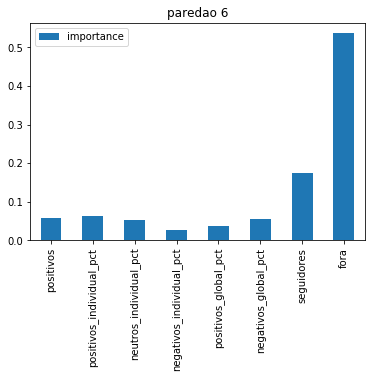

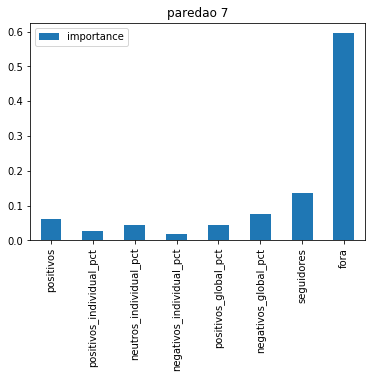

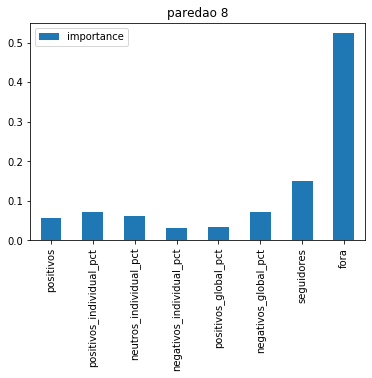

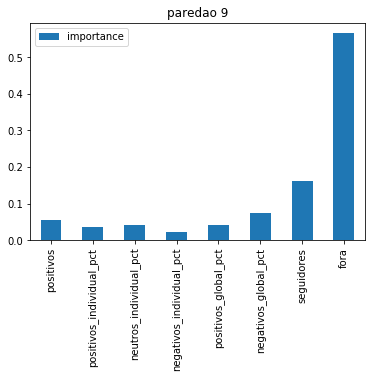

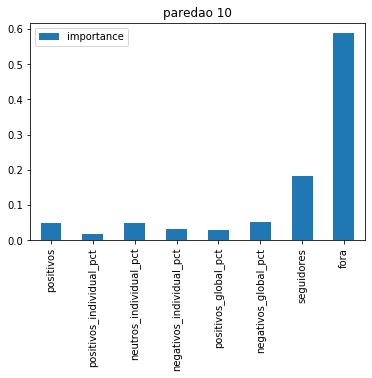

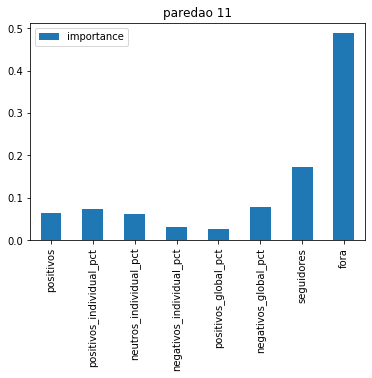

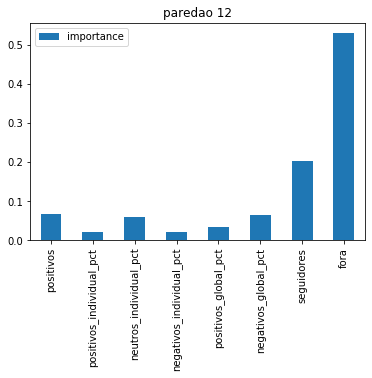

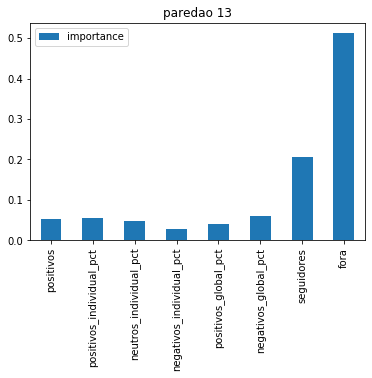

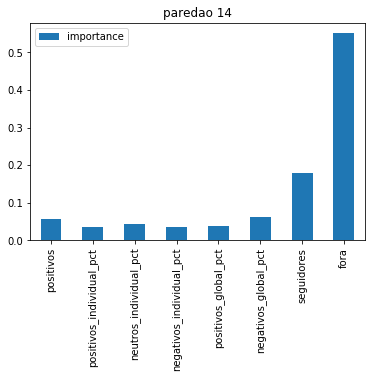

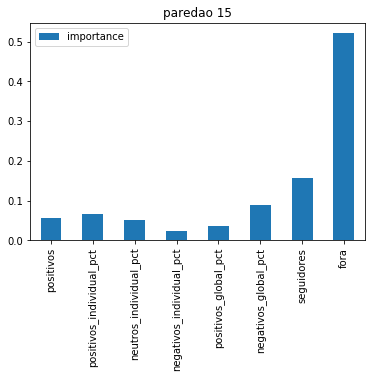

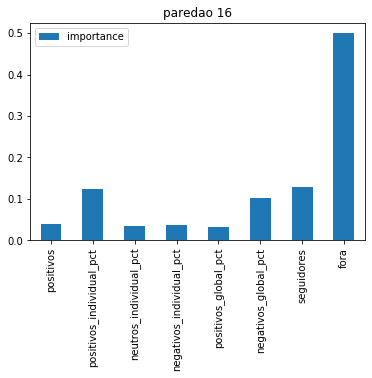

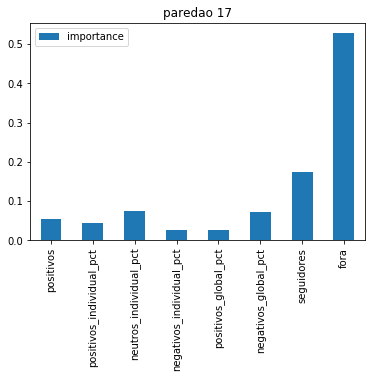

In [20]:
for i in range(1, 18):
    train_df, test_df = get_train_test(i, normalize=NORMALIZE, drop_columns=correlated_features)
    x_train, y_train = train_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), train_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()
    x_test, y_test = test_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), test_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()

    regressor = SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS))
    _ = regressor.fit(x_train, y_train)
    
    features = regressor.get_support()
    columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
    indexes = columns[features]
    features_importance = regressor.estimator_.feature_importances_

    summary_df["paredoes_decisivos"].loc[indexes] += 1
    summary_df["importancia_acumulada"] += features_importance

    pd.DataFrame(features_importance, index=columns, columns=["importance"]).plot.bar(title=f"paredao {i}")


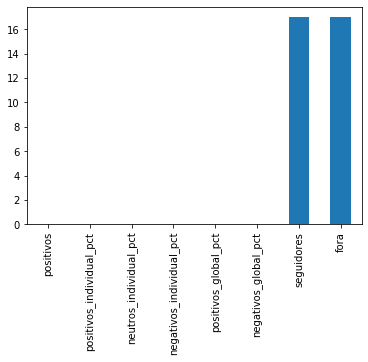

In [21]:
summary_df["paredoes_decisivos"].plot.bar()

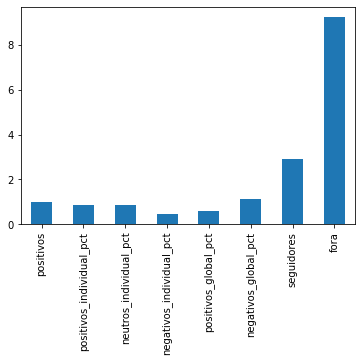

In [22]:
summary_df["importancia_acumulada"].plot.bar()

# Análise de paredões em conjunto

In [23]:
data_df = train_df.append(test_df, ignore_index=True)
x_train, y_train = data_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), data_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()
regressor = SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS))
_ = regressor.fit(x_train, y_train)

In [24]:
features = regressor.get_support()
columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
indexes = columns[features]
features_importance = regressor.estimator_.feature_importances_

summary_df["importancia_acumulada"] = features_importance

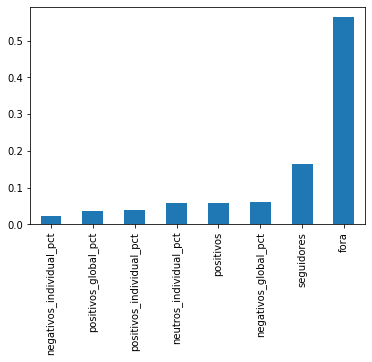

In [25]:
summary_df.sort_values(by="importancia_acumulada")["importancia_acumulada"].plot.bar()

In [26]:
summary_df.sort_values(by="importancia_acumulada", ascending=False)

,paredoes_decisivos,importancia_acumulada
fora,17,0.563668
seguidores,17,0.163070
negativos_global_pct,0,0.060680
positivos,0,0.059275
neutros_individual_pct,0,0.056711
positivos_individual_pct,0,0.038795
positivos_global_pct,0,0.035194
negativos_individual_pct,0,0.022606


# Combinando os resultados

In [27]:
summary_df["corr"] = [cor_target[index] for index in summary_df.index]
summary_df.drop("paredoes_decisivos", axis=1, inplace=True)

KeyError: 'positivos'

In [28]:
summary_df.sort_values(by=["importancia_acumulada", "corr"], ascending=False)

KeyError: 'corr'

# RFE


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [30]:
# train_df, test_df, _, _ = get_train_test(1, normalize=True, drop_columns=correlated_features)
train_df, test_df = get_train_test(1, normalize=False)
columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
data_df = train_df.append(test_df, ignore_index=True)
x_train, y_train = data_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), data_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()

In [31]:
#no of features       
best_score = 0
#Variable to store the optimum features
n_features = 0           
score_list =[]
for n in range(1, len(columns)+1):

    model = RandomForestRegressor(n_estimators=ESTIMATORS)
    rfe = RFE(model, n)
    X_train_rfe = rfe.fit_transform(x_train,y_train)
    preds = cross_val_predict(model, X_train_rfe, y_train, cv=10, n_jobs=5)
    score = r2_score(y_train, preds)
    score_list.append(score)
    # Quanto menor o mse melhor. Se utilizar r2, é necessário alterar aqui
    if(score > best_score):
        best_score = score
        n_features = n
print("Optimum number of features: {}".format(n_features))
print("Score with {} features: {}".format(n_features, best_score))

Optimum number of features: 4
Score with 4 features: 0.6477770399504645


In [32]:
estimator = RandomForestRegressor(n_estimators=ESTIMATORS)
selector = RFE(estimator, n_features, step=1)
selector.fit(x_train, y_train)

RFE(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                    criterion='mse', max_depth=None,
                                    max_features='auto', max_leaf_nodes=None,
                                    max_samples=None, min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=1,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=100, n_jobs=None,
                                    oob_score=False, random_state=None,
                                    verbose=0, warm_start=False),
    n_features_to_select=4, step=1, verbose=0)

In [33]:
feature_ranking_df = pd.DataFrame(columns=["feature", "rank"])
feature_ranking_df["feature"] = columns.to_list()
feature_ranking_df["rank"] = selector.ranking_
feature_ranking_df.sort_values(by="rank")

,feature,rank
16,fora,1
14,seguidores,1
10,day2,1
7,neutros_global_pct,1
15,fica,2
3,positivos_individual_pct,3
8,negativos_global_pct,4
4,neutros_individual_pct,5
12,likes,6
11,day3,7


In [34]:
rfe = RFECV(RandomForestRegressor(n_estimators=ESTIMATORS), scoring="r2", cv=10)

In [35]:
rfe = RFECV(LinearRegression(), scoring="r2", cv=10)

In [36]:
rfe.fit(x_train, y_train)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

In [37]:
rfe.n_features_

2

In [38]:
columns[rfe.support_]

Index(['neutros_individual_pct', 'negativos_individual_pct'], dtype='object')

In [39]:
rfe.grid_scores_[rfe.grid_scores_.argmax()]

0.08830031019333544

# F-regression

In [40]:
from sklearn.feature_selection import f_regression


In [41]:
F, pvals = f_regression(x_train, y_train)

In [42]:
feature_ranking_df["F"] = F
feature_ranking_df["pvals"] = pvals

In [43]:
feature_ranking_df.sort_values(by="rank")

,feature,rank,F,pvals
16,fora,1,10.103761,0.002590
14,seguidores,1,0.526959,0.471413
10,day2,1,0.436182,0.512128
7,neutros_global_pct,1,10.964144,0.001770
15,fica,2,0.043453,0.835756
3,positivos_individual_pct,3,10.809964,0.001894
8,negativos_global_pct,4,10.111858,0.002581
4,neutros_individual_pct,5,1.307233,0.258567
12,likes,6,0.452884,0.504196
11,day3,7,0.955672,0.333181
